# Modeling of mock data from SLITronomy paper

In this notebook we interested in fitting simulated lens systems from [Galan et al. 2021](https://ui.adsabs.harvard.edu/abs/2021A%26A...647A.176G/abstract). One goal is to compare source reconstructions. Another one is to fit _all_ parameters, i.e. including lens parameters (SIE, external shear), instead of assuming those to be perfectly known like for SLITronomy.

We employ the following _automated_ strategy, each time using knowledge from previous step to refine the model:

1. fit all parameters with smooth profiles only (lens and source), from parameters typically far from the truth;
2. fix lens parameters, and fit the source on a wavelet-regularized pixel grid;
3. fit all at once, both smooth lens parameters and pixelated source.

We can proceed to an additional interesting test: can residuals from step 1 above be abosorbed in perturbations to the lens potential instead?

3. (bis) fix all smooth parameters (lens and smooth), and fit for pixelated potential perturbations in the lens.

__last updated__: 05/08/21

In [1]:
# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

# Basic imports
import os
import numpy as np
import copy
from pprint import pprint
import pickle as pkl
import time
from matplotlib.colors import LogNorm
plt.rc('image', interpolation='none')

# Basic JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)

# jaxtronomy imports
from jaxtronomy.Coordinates.pixel_grid import PixelGrid
from jaxtronomy.Instrument.psf import PSF
from jaxtronomy.Instrument.noise import Noise
from jaxtronomy.LightModel.light_model import LightModel
from jaxtronomy.LensModel.lens_model import LensModel
from jaxtronomy.LensImage.lens_image import LensImage
from jaxtronomy.Parameters.parameters import Parameters
from jaxtronomy.Inference.loss import Loss
from jaxtronomy.Inference.optimization import Optimizer
from jaxtronomy.Analysis.plot import Plotter
from jaxtronomy.Util import image_util

# Universal font size
FS = 18

# Global settings
max_iterations = 1000
init_learning_rate = 1e-3

# Plotting engine for modeling results
plotter = Plotter(base_fontsize=FS, flux_vmin=1e-2, flux_vmax=3e0, res_vmax=4)

In [2]:
# select the type of source: 'single' or 'group'
source_type = 'single'

### Data grids

In [3]:
pkl_filename = f'slitronomy-mock_mocksource-highres-{source_type}_ssres-3.pkl'
#pkl_filename = f'slitronomy-mock_mocksource-highres-{source_type}_ssres-3.pkl'
with open(os.path.join('data', 'SLITronomy', pkl_filename), 'rb') as f:
    mock_alldata = pkl.load(f)

class_list, kwargs_true_lens, kwargs_true_source, source_sim_comp, source_sim_data_res = mock_alldata
data_class, psf_class = class_list
data = data_class.data

npix, npix_y = data_class.num_pixel_axes
pix_scl = data_class.pixel_width  # arcsec / pixel
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2
transform_pix2angle = pix_scl * np.eye(2)
kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}
pixel_grid = PixelGrid(**kwargs_pixel)
xgrid, ygrid = pixel_grid.pixel_coordinates
extent = pixel_grid.extent

# update plotter with data
plotter.set_data(data)

print(f"image size : ({npix}, {npix_y}) pixels")
print(f"pixel size : {pix_scl} arcsec")
print(f"x range    : {xgrid[0, 0], xgrid[0, -1]} arcsec")
print(f"y range    : {ygrid[0, 0], ygrid[-1, 0]} arcsec")

kwargs_numerics = {'supersampling_factor': 1, 'convolution_type': 'grid'}

image size : (100, 100) pixels
pixel size : 0.07999999999999999 arcsec
x range    : (-3.9599999999999995, 3.9599999999999995) arcsec
y range    : (-3.9599999999999995, 3.9599999999999995) arcsec


### Visualize data

-0.17952851894689326


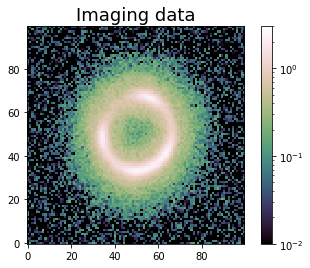

In [4]:
print(data.min())

plt.title("Imaging data", fontsize=FS)
plt.imshow(data, origin='lower', cmap=plotter.cmap_flux, norm=plotter.norm_flux)
plt.colorbar()
plt.show()

### Noise

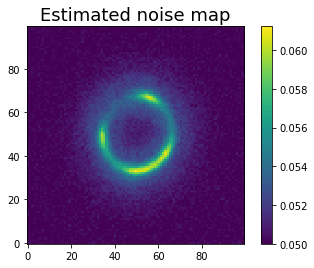

In [5]:
# here we know the true exposure time and background noise level
kwargs_noise = {'background_rms': data_class.background_rms, 
                'exposure_time': data_class.exposure_map}
noise = Noise(npix, npix, **kwargs_noise)
noise.set_data(data)

plt.title("Estimated noise map", fontsize=FS)
plt.imshow(np.sqrt(noise.C_D), origin='lower')
#plt.imshow(np.sqrt(data_class.C_D), origin='lower')
plt.colorbar()
plt.show()

### PSF

In [6]:
kwargs_psf = {'psf_type': 'PIXEL', 'kernel_point_source': psf_class.kernel_point_source}
psf = PSF(**kwargs_psf)

## 1) Analytical lens + analytical smooth source modeling

Here we choose only smooth profile for a first rough model.

### Define modeling choices and initial parameter values

In [7]:
# Source light
source_light_model_list = ['SERSIC_ELLIPSE']
source_light_model = LightModel(source_light_model_list)

# Lens mass
lens_mass_model_list = ['SIE', 'SHEAR_GAMMA_PSI']
lens_mass_model = LensModel(lens_mass_model_list)

# Create the model
lens_image_allsmooth = LensImage(pixel_grid, psf, noise_class=noise,
                         lens_model_class=lens_mass_model,
                         source_model_class=source_light_model,
                         kwargs_numerics=kwargs_numerics)

kwargs_model = {
    'lens_model_list': lens_mass_model_list,
    'source_model_list': source_light_model_list,
    'lens_light_model_list': [],
}
kwargs_init = {
    'kwargs_lens': [{'theta_E': 1.4, 'e1': 1e-3, 'e2': 1e-3, 'center_x': 1e-3, 'center_y': 1e-3}, {'gamma_ext': 1e-3, 'psi_ext': 1e-3}],
    'kwargs_source': [{'amp': 20., 'R_sersic': 0.8, 'n_sersic': 2., 'e1': 1e-3, 'e2': 1e-3, 'center_x': 1e-3, 'center_y': 1e-3}],
    'kwargs_lens_light': [{}],
}
kwargs_prior = {
    'kwargs_lens': [{}, {}],
    'kwargs_source': [{}],
    'kwargs_lens_light': [{}],
}
kwargs_fixed = {
    'kwargs_lens': [{'center_x': 0., 'center_y': 0.}, {'ra_0': 0., 'dec_0': 0.}],
    'kwargs_source': [{}],
    'kwargs_lens_light': [{}],
}
parameters_allsmooth = Parameters(lens_image_allsmooth, kwargs_init, kwargs_prior, kwargs_fixed)

kwargs_true_approx_smooth = {'kwargs_lens': kwargs_true_lens, 'kwargs_source': copy.deepcopy(kwargs_init['kwargs_source']), 'kwargs_lens_light': []}
p_true_approx_smooth = copy.deepcopy(parameters_allsmooth.kwargs2args(kwargs_true_approx_smooth))
print("num. parameters:", parameters_allsmooth.num_parameters)

num. parameters: 12


### Visualise initial model

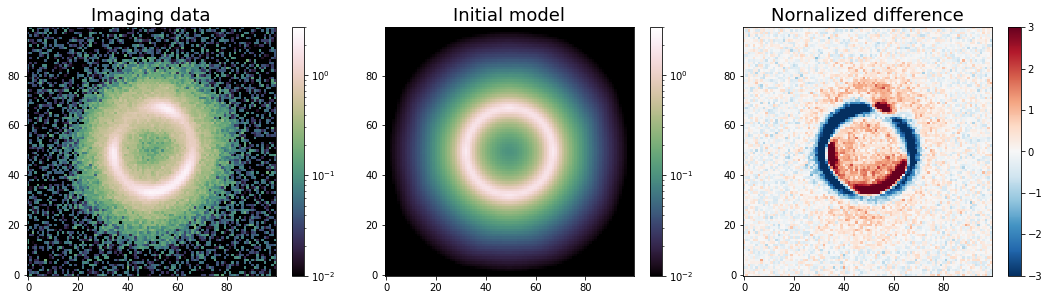

In [8]:
init_model = lens_image_allsmooth.model(**kwargs_init)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
ax = axes[0]
ax.set_title("Imaging data", fontsize=FS)
img = ax.imshow(data, origin='lower', cmap=plotter.cmap_flux, norm=plotter.norm_flux)
fig.colorbar(img, ax=ax)
ax = axes[1]
ax.set_title("Initial model", fontsize=FS)
img = ax.imshow(init_model, origin='lower', cmap=plotter.cmap_flux, norm=plotter.norm_flux)
fig.colorbar(img, ax=ax)
ax = axes[2]
ax.set_title("Nornalized difference", fontsize=FS)
img = ax.imshow(data/data.mean()-init_model/init_model.mean(), origin='lower', cmap='RdBu_r', vmin=-3, vmax=3)
fig.colorbar(img, ax=ax)
fig.tight_layout()

### Optimize parameters

In [9]:
loss_allsmooth = Loss(data, lens_image_allsmooth, parameters_allsmooth, likelihood_type='chi2')
optimizer_allsmooth = Optimizer(loss_allsmooth, parameters_allsmooth)
print(optimizer_allsmooth.loss(p_true_approx_smooth))

5.6105897403554295


In [10]:
# Optimise !
best_fit, logL, extra_fields, runtime \
    = optimizer_allsmooth.minimize(method='BFGS', restart_from_init=True)
print(f"Runtime: {runtime}")
kwargs_final_allsmooth = copy.deepcopy(parameters_allsmooth.best_fit_values(as_kwargs=True))
pprint(kwargs_final_allsmooth)
#print(extra_fields['result_class'])  # uncomment for full scipy summary

Runtime: 7.799695014953613
{'kwargs_lens': [{'center_x': 0.0,
                  'center_y': 0.0,
                  'e1': array(0.1393992),
                  'e2': array(-0.02453083),
                  'theta_E': array(1.33533041)},
                 {'dec_0': 0.0,
                  'gamma_ext': array(0.02059058),
                  'psi_ext': array(0.53293285),
                  'ra_0': 0.0}],
 'kwargs_lens_light': [],
 'kwargs_source': [{'R_sersic': array(2.63158111),
                    'amp': array(4.58650929),
                    'center_x': array(0.05536911),
                    'center_y': array(0.06867699),
                    'e1': array(-0.10408936),
                    'e2': array(-0.00286514),
                    'n_sersic': array(3.71466216)}]}


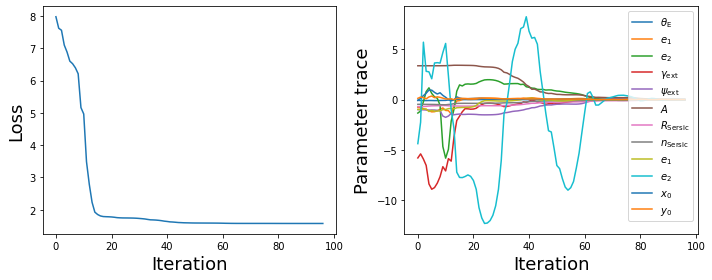

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes[0]
ax.plot(range(len(optimizer_allsmooth.loss_history)), optimizer_allsmooth.loss_history)
ax.set_ylabel("Loss", fontsize=FS)
ax.set_xlabel("Iteration", fontsize=FS)
ax = axes[1]
param_history = np.array(optimizer_allsmooth.param_history)
for i in range(len(parameters_allsmooth.names)):
    ax.plot(range(len(optimizer_allsmooth.loss_history)), (param_history[:, i] - param_history[-1, i]) / param_history[-1, i], label=parameters_allsmooth.symbols[i])
ax.set_ylabel("Parameter trace", fontsize=FS)
ax.set_xlabel("Iteration", fontsize=FS)
ax.legend(loc='upper right')
fig.tight_layout()
plt.show()

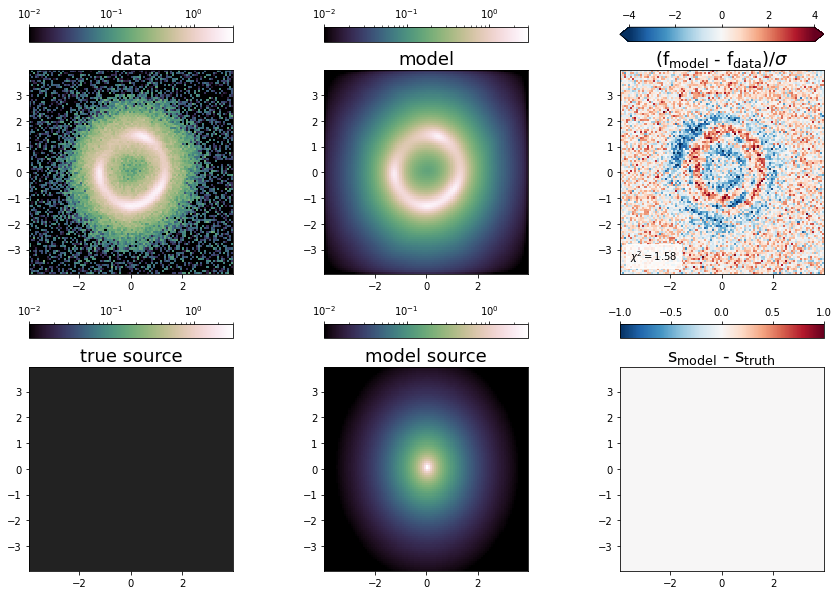

In [12]:
plotter.model_summary(lens_image_allsmooth, kwargs_final_allsmooth)

In [13]:
def print_errors(kwargs):
    def _print_error(name, value, estimate):
        spaces = " " * (10 - len(name))
        if value != 0:
            error = 100 * abs(value - estimate) / value
            print(name + ":" + spaces + f"{error:.2f} % ({value} => {estimate})")
        else:
            error = abs(value - estimate)
            print(name + ":" + spaces + f"{error:.2f} [abs] ({value} => {estimate})")
    print("Error")
    print("-----")
    for i, params in enumerate(kwargs_true_lens):
        for key, value in params.items():
            fit = kwargs['kwargs_lens'][i][key]
            _print_error(key, value, fit)
    #for i, params in enumerate(kwargs_source_light):
    #    for key, value in params.items():
    #        fit = kwargs['kwargs_source'][i][key]
    #        _print_error(key, value, fit)
        
print_errors(kwargs_final_allsmooth)

print("\nSource parameters\n-----")
pprint(kwargs_final_allsmooth['kwargs_source'][0])

Error
-----
theta_E:   0.34 % (1.330841155341295 => 1.3353304055983113)
center_x:  0.00 [abs] (0 => 0.0)
center_y:  0.00 [abs] (0 => 0.0)
e1:        25.46 % (0.11111111111111108 => 0.13939920384818505)
e2:        0.02 [abs] (0.0 => -0.024530827039143183)
gamma_ext: 31.36 % (0.03 => 0.020590576058856586)
psi_ext:   32.14 % (0.7853981633974483 => 0.532932853334224)
ra_0:      0.00 [abs] (0 => 0.0)
dec_0:     0.00 [abs] (0 => 0.0)

Source parameters
-----
{'R_sersic': array(2.63158111),
 'amp': array(4.58650929),
 'center_x': array(0.05536911),
 'center_y': array(0.06867699),
 'e1': array(-0.10408936),
 'e2': array(-0.00286514),
 'n_sersic': array(3.71466216)}


## 2) Pixelated source modeling with fixed smooth lens

Here we optimise the source light on a grid of wavelet-regularized pixels, fixing the lens parameters to their previous values

In [14]:
# Source light
kwargs_pixelated_source = {
    'pixel_scale_factor': 1,
    'grid_shape': (4, 4),
}
source_light_model_list = ['PIXELATED']
source_light_model = LightModel(source_light_model_list, 
                                pixel_interpol='bilinear',
                                kwargs_pixelated=kwargs_pixelated_source)

# Lens mass
lens_mass_model_list = ['SIE', 'SHEAR_GAMMA_PSI']
lens_mass_model = LensModel(lens_mass_model_list)

lens_image_pixsource = LensImage(pixel_grid, psf, noise_class=noise,
                         lens_model_class=lens_mass_model,
                         source_model_class=source_light_model,
                         kwargs_numerics=kwargs_numerics)

# update plotter with true source (little tricky to make sure it has the same shape as the reconstructed source)
if kwargs_pixelated_source['pixel_scale_factor'] == 1/3.:
    true_source = source_sim_comp  # we know source_sim_comp is (300, 300)
elif kwargs_pixelated_source['pixel_scale_factor'] < 1:
    x_coords, y_coords = lens_image_pixsource.Grid.pixel_axes
    x_coords_src, y_coords_src = lens_image_pixsource.Grid.model_pixel_axes('source')
    true_source = image_util.re_size_array(x_coords, y_coords, source_sim_data_res, x_coords_src, y_coords_src)
else:
    true_source = source_sim_data_res
plotter.set_true_source(true_source)

kwargs_model = {
    'lens_model_list': lens_mass_model_list,
    'source_model_list': source_light_model_list,
    'lens_light_model_list': [],
}
kwargs_init = {
    'kwargs_lens': [{'theta_E': 1.4, 'e1': 1e-3, 'e2': 1e-3, 'center_x': 1e-3, 'center_y': 1e-3}, {'gamma_ext': 1e-3, 'psi_ext': 1e-3}],
    'kwargs_source': [{'pixels': 1e-8}],
    'kwargs_lens_light': [{}],
}
kwargs_prior = {
    'kwargs_lens': [{}, {}],
    'kwargs_source': [{}],
    'kwargs_lens_light': [{}],
}
kwargs_fixed = {
    'kwargs_lens': copy.deepcopy(kwargs_final_allsmooth['kwargs_lens']),
    'kwargs_source': [{}],
    'kwargs_lens_light': [{}],
}
parameters_pixsource = Parameters(lens_image_pixsource, kwargs_init, kwargs_prior, kwargs_fixed)
kwargs_true = {'kwargs_lens': kwargs_true_lens, 
                 'kwargs_source': [{'pixels': true_source}],
                 'kwargs_lens_light': []}
#p_true = copy.deepcopy(parameters_pixsource.kwargs2args(kwargs_true))
#print("num. parameters:", parameters_pixsource.num_parameters)

In [15]:
loss_pixsource = Loss(data, lens_image_pixsource, parameters_pixsource, 
                      likelihood_type='l2_norm',
                      regularization_terms=['l1_starlet_source', 
                                            'l1_battle_source',
                                            'positivity_source'], 
                      regularization_strengths=[3, 3, 3])
optimizer_pixsource = Optimizer(loss_pixsource, parameters_pixsource)
#print(loss_pixsource(p_true))

In [16]:
best_fit, logL_best_fit, extra_fields, runtime \
    = optimizer_pixsource.optax(max_iterations=max_iterations, 
                                init_learning_rate=init_learning_rate,
                                restart_from_init=True)
print(f"Runtime: {runtime} s")
print(f"Final loss: {logL_best_fit:.2f}")
kwargs_final_pixsource = parameters_pixsource.best_fit_values(as_kwargs=True)

Runtime: 35.463436126708984 s
Final loss: 1.81


/Users/aymericg/Documents/EPFL/PhD_LASTRO/Code/Lens_modelling/autodiff/jax-strong-lensing/jaxtronomy/Analysis/plot.py:127: UserWarning: True source array has been interpolated to match model array
  warnings.warn("True source array has been interpolated to match model array")


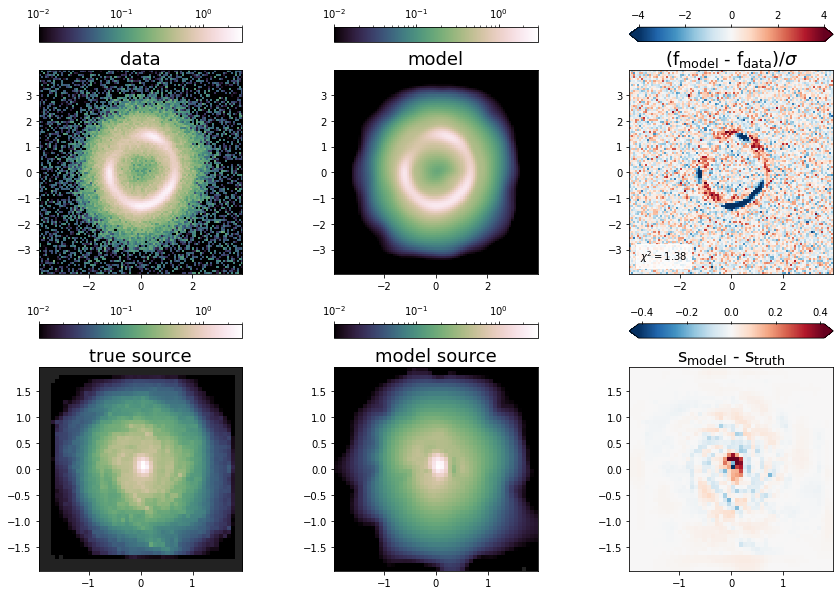

In [17]:
plotter.model_summary(lens_image_pixsource, kwargs_final_pixsource)

In [18]:
print_errors(kwargs_final_pixsource)

Error
-----
theta_E:   0.34 % (1.330841155341295 => 1.3353304055983113)
center_x:  0.00 [abs] (0 => 0.0)
center_y:  0.00 [abs] (0 => 0.0)
e1:        25.46 % (0.11111111111111108 => 0.13939920384818505)
e2:        0.02 [abs] (0.0 => -0.024530827039143183)
gamma_ext: 31.36 % (0.03 => 0.020590576058856586)
psi_ext:   32.14 % (0.7853981633974483 => 0.532932853334224)
ra_0:      0.00 [abs] (0 => 0.0)
dec_0:     0.00 [abs] (0 => 0.0)


## 3) Optimize pixelated source and smooth lens

In [19]:
kwargs_fixed = {
    # unfix everything, including the SIE center as well
    'kwargs_lens': [{}, {'ra_0': 0., 'dec_0': 0.}],
    'kwargs_source': [{}],
    'kwargs_lens_light': [{}],
}
parameters_pixsource.update_fixed(kwargs_fixed)
print("num. parameters:", parameters_pixsource.num_parameters)

num. parameters: 2507


In [20]:
best_fit, logL_best_fit, extra_fields, runtime \
    = optimizer_pixsource.optax(max_iterations=max_iterations, 
                                init_learning_rate=init_learning_rate,
                                restart_from_init=False)
print(f"Runtime: {runtime} s")
print(f"Final loss: {logL_best_fit:.2f}")
kwargs_final_final = parameters_pixsource.best_fit_values(as_kwargs=True)

Runtime: 33.54035472869873 s
Final loss: 1.40


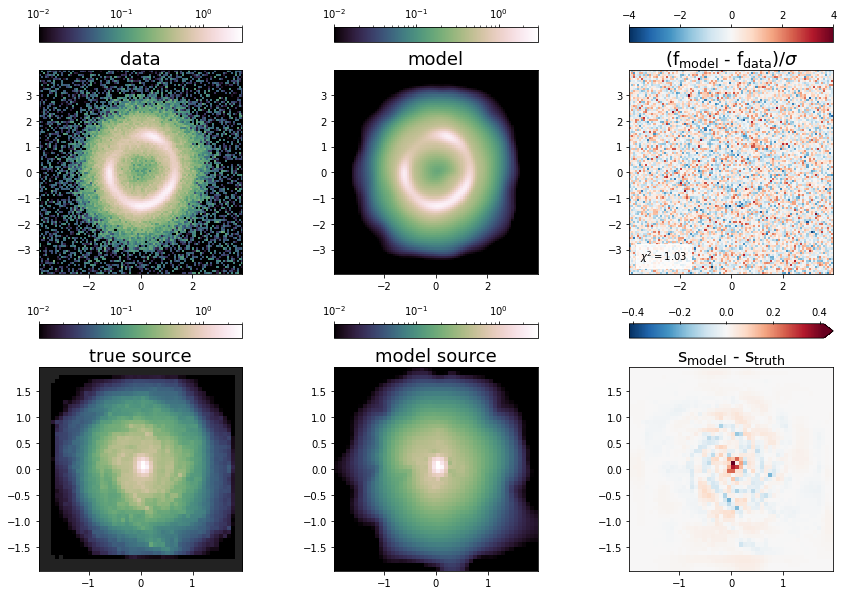

In [21]:
plotter.model_summary(lens_image_pixsource, kwargs_final_final)

In [22]:
print_errors(kwargs_final_final)

Error
-----
theta_E:   0.40 % (1.330841155341295 => 1.3361910298121467)
center_x:  0.01 [abs] (0 => -0.014429373735647436)
center_y:  0.01 [abs] (0 => -0.007995715518133929)
e1:        32.53 % (0.11111111111111108 => 0.14725015035547462)
e2:        0.02 [abs] (0.0 => -0.024815203954854433)
gamma_ext: 27.83 % (0.03 => 0.02165111717009381)
psi_ext:   35.01 % (0.7853981633974483 => 0.5104023774394112)
ra_0:      0.00 [abs] (0 => 0.0)
dec_0:     0.00 [abs] (0 => 0.0)


## 2) _bis_ Can residuals from step 1 be absorbed with potential perturbations?

Model residuals worsen, and the best-fit potential perturbations are non-physical. In addition, using another optimizer (e.g. `optax`) instead if `scipy.minimize` leads to a completely different solution.

$\Longrightarrow$ Residuals from step 1 cannot be absorbed into potential perturbations!